# Load the environment variables

In [ ]:
# 0. Load the environment variables
import locale
locale.getpreferredencoding = lambda: "UTF-8"

import os
import yaml

with open(r"Math Agent\gemini_key1.yaml", 'r') as file:
    api_creds = yaml.safe_load(file)
os.environ["GOOGLE_API_KEY"] = api_creds['gemini_key']

with open(r"Math Agent\tavily_key.yaml", 'r') as file:
    api_creds = yaml.safe_load(file)
os.environ["TAVILY_API_KEY"] = api_creds['tavily_key']

# Import Required Libraries

In [2]:
# 1. Import Required Libraries

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain.schema import Document
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict
import os
import json
from pylatexenc.latex2text import LatexNodes2Text
import re
from pathlib import Path
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Read the JSON files from the dataset

In [ ]:
# 2. Read the JSON files from the dataset

# LaTeX Cleaning Functions
def clean_latex(latex_str):
    latex_str = latex_str.replace('\\\\', '\\')
    latex_str = re.sub(r"\\\[|\\\]", "", latex_str)
    latex_str = re.sub(r"\$+", "", latex_str)
    return latex_str

def latex_to_text(latex_str):
    cleaned = clean_latex(latex_str)
    return LatexNodes2Text().latex_to_text(cleaned)

# Dataset Loader with Cleaning
def load_math_dataset(base_path):
    """
    Loads JSON files from topic folders, cleans LaTeX, and returns LangChain Documents.
    """
    documents = []

    for topic_folder in os.listdir(base_path):
        topic_path = os.path.join(base_path, topic_folder)
        
        if not os.path.isdir(topic_path):
            continue

        for file_name in os.listdir(topic_path):
            if file_name.endswith(".json"):
                file_path = os.path.join(topic_path, file_name)

                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                    # Extract and clean problem and solution text
                    problem = data.get("problem", "")
                    solution = data.get("solution", "")
                    level = data.get("level", "")
                    qtype = data.get("type", "")

                    clean_problem = latex_to_text(problem.strip())
                    clean_solution = latex_to_text(solution.strip())

                    content = f"Problem:\n{clean_problem}\n\nSolution:\n{clean_solution}"
                    metadata = {
                        "level": level,
                        "type": qtype
                    }

                    documents.append(Document(page_content=content, metadata=metadata))

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

    print(f"Loaded {len(documents)} documents.")
    return documents

# Load the dataset from the specified path
dataset_path = r"Math Agent\data\MATH"
all_documents = load_math_dataset(dataset_path)

Loaded 12500 documents.


# Initialize LLM and Embedding Model

In [4]:
# 3. Initialize LLM and Embedding Model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0
)

embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-en",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

# Create or Load Chroma Index

In [5]:
# 4. Create or Load Chroma Index

if os.path.exists("./math_db"):
    chroma_db = Chroma(
    embedding_function=embedding_model,
    persist_directory="./math_db",
    collection_name="math_knowledge"
    )
    print("Chroma index loaded from disk.")
else:
    chroma_db = Chroma.from_documents(
    all_documents,
    embedding=embedding_model,
    persist_directory="./math_db",
    collection_name="math_knowledge"
    )
    print("Chroma index created and saved to disk.")

Chroma index loaded from disk.


# Retriever with Similarity Threshold

In [6]:
# 5. Retriever with Similarity Threshold

retriever = chroma_db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        "k": 3,
        "score_threshold": 0.8 
    }
)

query = """How do you find the area of a trapezoid?"""
results = retriever.get_relevant_documents(query)

print("\n📚 Retrieved Documents:")
for doc in results:
    print(doc.page_content)
    print("--------------------------------------------------------")


📚 Retrieved Documents:
Problem:
What is the area, in square units, of a trapezoid bounded by the lines y = x, y = 10, y = 5 and the y-axis? Express your answer as a decimal to the nearest tenth.

Solution:
The vertices of the trapezoid are (5,5), (10,10), (0,10), and (0,5).  Its bases are 5 and 10 units long, and its height is 5 units.  Averaging the bases and multiplying by the height, we find an area of (5+10/2)(5)=37.5 square units.

[asy]
unitsize(2mm);
defaultpen(linewidth(.7pt)+fontsize(8pt));
dotfactor=4;

fill((5,5)–(10,10)–(0,10)–(0,5)–cycle,gray);

draw((-12,-12)–(14,14),Arrows(4));
draw((-14,10)–(14,10),Arrows(4));
draw((-14,5)–(14,5),Arrows(4));

draw((-15,0)–(15,0),Arrows(4));
draw((0,-15)–(0,15),Arrows(4));

label("y=x",(14,14),NE);
label("y=10",(14,10),E);
label("y=5",(14,5),E);[/asy]
--------------------------------------------------------
Problem:
An isosceles trapezoid has sides of length 4 cm, 10 cm, 16 cm and 10 cm. What is the area of this trapezoid, in square cen

# Graph State

In [7]:
# 6. Graph State
class GraphState(TypedDict):
    question: str
    raw_solution: str
    generation: str
    documents: List[Document]
    web_search_needed: str
    web_search_sufficient: str
    web_results: str
    human_feedback: str
    should_end: bool

# Input Guardrails

In [8]:
# 7. Input Guardrails
# This guardrail checks if the question is math-related.
# If not, it returns a message indicating that only math questions are allowed.

input_guard_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a mathematics teaching assistant. Only answer questions related to mathematics. 
    If not a math query, say: 'I'm sorry, I can only help with math questions.'"""),
    ("human", "{question}")
])

input_guard_chain = input_guard_prompt | llm | StrOutputParser()

def input_guardrails(state):
    print("🧠 Running Input Guardrails: Checking if the question is math-related...")
    question = state["question"]
    response = input_guard_chain.invoke({"question": question})
    
    # If it's not math-related
    if "I'm sorry, I can only help with math questions." in response:
        #return {**state, "generation": response, "documents": []}
        return {**state, "generation": response, "should_end": True}
    
    # Otherwise continue with an empty generation
    return {**state, "generation": ""}

# Retrieve Documents

In [9]:
# 8. Retrieve Documents

def retrieve(state):
    print("📥 Retrieving from Knowledge Base...")
    question = state["question"]
    if state.get("generation") and "I'm sorry" in state["generation"]:
        return state
    docs = retriever.get_relevant_documents(question)
    return {**state, "documents": docs}

# Document Grader

In [10]:
# 9. Document Grader
grader_prompt = ChatPromptTemplate.from_template("""
You are a document relevance grader.

Question:
{question}

Documents:
{documents}

Your task is to:
1. Identify which documents are relevant to the question.
2. Determine if at least one of the relevant documents is sufficient to answer the question.
3. Output a JSON with:
- "relevant_documents": [list of indices of relevant docs],
- "is_sufficient": true/false

Return your output as JSON only.
""")

eval_llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0
)

parser = JsonOutputParser()

def grade_documents(inputs):
    question = inputs["question"]
    documents = [doc.page_content for doc in inputs["documents"]]
    return {"question": question, "documents": documents}
document_grader_chain = RunnableLambda(grade_documents) | grader_prompt | eval_llm | parser

def document_grader(state):
    if not state["documents"]:
        return {**state, "web_search_needed": "Yes"}
    result = document_grader_chain.invoke({"question": state["question"], "documents": state["documents"]})
    relevant_indices = result.get("relevant_documents", [])
    is_sufficient = result.get("is_sufficient", False)
    relevant_docs = [state["documents"][i] for i in relevant_indices]
    print(f"🗂️ Document Grader Result: {len(relevant_docs)} relevant docs found. ✅ Sufficient: {is_sufficient}")
    return {
        **state,
        "documents": relevant_docs,
        "web_search_needed": "No" if is_sufficient else "Yes"
    }

# Web Search Tool

In [11]:
# 10. Web Search Tool

web_search_tool = TavilySearchResults(max_results=3, search_depth='advanced', max_tokens=10000)

def web_search(state):
    if state.get("web_search_needed") == "Yes":
        print("🌐 No sufficient documents. Performing Web Search...")
        
        # Perform web search
        results = web_search_tool.invoke({"query": state["question"]})
        
        # Check if results are empty
        if not results:
            return {**state, "web_results": "", "web_search_sufficient": "No"}
        
        # Combine contents of the search results
        web_context = "\n\n".join(r["content"] for r in results)
        
        # Add this web search assessment step
        return {**state, "web_results": web_context, "web_search_sufficient": "Unknown"}
    
    return {**state, "web_results": "", "web_search_sufficient": "NotNeeded"}


# Web Results Assessment

In [12]:
# 11. Web Results Assessment

def assess_web_results(state):
    # Skip if web search wasn't needed
    if state["web_search_sufficient"] == "NotNeeded":
        return state
    
    # Skip if web results are already known to be insufficient
    if state["web_search_sufficient"] == "No":
        return {**state, "generation": "❌ Sorry, I couldn't find any reliable information online to answer your question."}
    
    # Define the assessment prompt
    assess_prompt = ChatPromptTemplate.from_messages([
        ("system", 
         "You are a mathematics expert evaluating whether web search results contain sufficient information to solve a math problem."
         "Your task is to determine if the provided web content has relevant mathematical information to answer the question."
         "Return ONLY 'Yes' if the content is sufficient, or 'No' if it lacks necessary information."),
        ("human", 
         "Question: {question}\n\nWeb Content:\n{web_results}")
    ])
    
    assessment_chain = assess_prompt | llm | StrOutputParser()
    result = assessment_chain.invoke({
        "question": state["question"],
        "web_results": state["web_results"]
    })
    
    print(f"🔍 Web Results Assessment: {result}")
    
    if "No" in result:
        # return {**state, 
        #         "web_search_sufficient": "No", 
        #         "generation": "Sorry, I couldn't find any reliable information online to answer your question."}
        return {**state, 
                "web_search_sufficient": "No", 
                "generation": "❌ Sorry, I couldn't find any reliable information online to answer your question.",
                "should_end": True}
    
    return {**state, "web_search_sufficient": "Yes", "should_end": False}

# Final Generation

In [13]:
# 12. Final Generation

def generate(state):
    # If we already have a solution, do nothing
    if state.get("raw_solution") and not state.get("human_feedback"):
            return state

    # Build context from KB docs + web results
    docs = "\n\n".join(doc.page_content for doc in state.get("documents", []))
    web = state.get("web_results", "")
    feedback = state.get("human_feedback", "")
    context = docs + "\n\n" + web

    # Create and invoke the chain
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
        "You are a expert mathematics professor helping students understand the math problems clearly.\n\n"
        "Your task is to:\n"
        "1. Understand the math question.\n"
        "2. Use the provided context to identify key formulas, definitions, or values.\n"
        "3. Solve the question step-by-step using clear reasoning and intermediate steps.\n"
        "4. Show all formulas and substitutions, and explain your logic.\n"
        "5. End with a final boxed answer like: \\boxed{{your_final_answer}}.\n"
        "6. If human feedback is provided, follow the human feedback carefully to improve or correct your previous answer.\n\n"
        "Do not skip steps, and ensure clarity for someone learning math."),
        
        ("human", 
        "Human Feedback:\n{feedback_block}\n\nContext:\n{context}\n\nQuestion:\n{question}")
    ])

    # Add feedback if any
    feedback_block = f"Human Feedback: {feedback}" if feedback else ""
    chain = prompt | llm | StrOutputParser()
    raw = chain.invoke({"context": context, "question": state["question"], "feedback_block": feedback_block})

    # Store the raw solution separately, leave generation empty for now
    return {**state, "raw_solution": raw, "generation": ""}


# Output Guardrails

In [14]:
# 13. Output Guardrails
# This is the final check to ensure the solution is correct and complete.

def output_guardrails(state):
    raw = state.get("raw_solution", "")
    if not raw:
        return state

    check_prompt = ChatPromptTemplate.from_messages([
        ("system", 
        "You are a mathematics expert responsible for validating the accuracy and completeness of step-by-step solutions.\n\n"
        "Given a math question and a proposed solution:\n"
        "1. If the solution is entirely correct, includes all necessary steps, and clearly explains the reasoning, return the solution exactly as-is.\n"
        "2. If the solution is incorrect, missing key steps, or lacks clear logic, rewrite it completely with detailed, correct, step-by-step reasoning.\n\n"
        "Do not include any additional commentary or notes. Return only the corrected (or confirmed) solution."),
        
        ("human", 
        "Question:\n{question}\n\nProposed Solution:\n{raw_solution}")
    ])

    chain = check_prompt | eval_llm | StrOutputParser()
    validated = chain.invoke({
        "question": state["question"],
        "raw_solution": raw
    })

    # Place the final solution into 'generation'
    return {**state, "generation": validated}


# Human-in-the-Loop Feedback Function

In [15]:
# 14. Human-in-the-Loop Feedback Function
# Function to save feedback to disk

def save_feedback(question, solution, feedback, rating=None):
    feedback_file = Path("./feedback_data/feedback_log.json")
    feedback_file.parent.mkdir(exist_ok=True, parents=True)

    # Use readable datetime format
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    entry = {
        "timestamp": timestamp,
        "question": question,
        "solution": solution,
        "feedback": feedback,
        "rating": rating
    }

    # Load existing data if file exists
    if feedback_file.exists():
        with open(feedback_file, "r") as f:
            try:
                feedback_data = json.load(f)
            except json.JSONDecodeError:
                feedback_data = []
    else:
        feedback_data = []

    # Append the new entry
    feedback_data.append(entry)

    # Save back to the file
    with open(feedback_file, "w") as f:
        json.dump(feedback_data, f, indent=2)

    print(f"📝 Feedback logged at {timestamp}")

def human_in_the_loop(state):
    print("\n🔎 MATH Agent: Here's the generated solution:")
    print("="*50)
    print("💬 Question: "+state["question"])
    plain_text = latex_to_text(state["generation"])
    print("📝 Response: \n"+plain_text)
    print("="*50)
    
    rating = input("\n⭐ Rate this solution (1-5): ").strip()
    try:
        rating = int(rating)
        if not (1 <= rating <= 5):
            rating = 0
    except ValueError:
        rating = 0
    
    approval = input("\n❓ Do you approve this answer? (yes / no): ").strip().lower()
    if approval == "yes":
        save_feedback(state["question"], state["generation"], "", rating=rating)
        return {**state, "human_feedback": ""}
    
    feedback = input("✏️ Please enter your correction or feedback: ").strip()
    
    # Save feedback for future improvements
    save_feedback(state["question"], state["generation"], feedback, rating=rating)
    
    # Store feedback and send back to generate phase
    return {**state, "human_feedback": feedback, "generation": ""}

# stop() to end the workflow

In [16]:
# 15. stop() to end the workflow
# This function is called when the workflow need to end at intermediate state.

def stop(state):
    print("=========================================================")
    print(state["generation"])
    return state

# State Graph

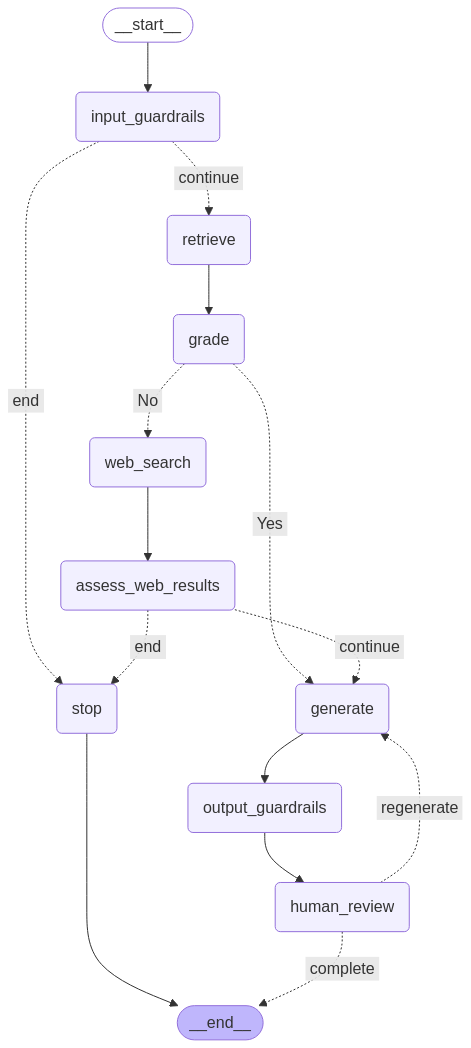

In [17]:
# 16. State Graph

agent = StateGraph(GraphState)

agent.add_node("input_guardrails", input_guardrails)
agent.add_node("retrieve", retrieve)
agent.add_node("grade", document_grader)
agent.add_node("web_search", web_search)
agent.add_node("assess_web_results", assess_web_results)
agent.add_node("generate", generate)
agent.add_node("output_guardrails", output_guardrails)
agent.add_node("human_review", human_in_the_loop)
agent.add_node("stop", stop)
agent.add_edge("stop", END)

agent.set_entry_point("input_guardrails")

agent.add_conditional_edges(
    "input_guardrails",
    lambda state: "end" if state.get("should_end", False) else "continue",
    {
        "end": "stop",
        "continue": "retrieve"
    }
)

agent.add_edge("retrieve", "grade")
agent.add_conditional_edges(
    "grade", 
    lambda state: "No" if state["web_search_needed"] else "Yes",
    {
        "Yes": "generate",     # Use retrieved docs
        "No": "web_search"     # Perform web search if no relevant doc
    }
)
agent.add_edge("web_search", "assess_web_results")
agent.add_conditional_edges(
    "assess_web_results",
    lambda state: "end" if state.get("should_end", False) else "continue",
    {
        "end": "stop",
        "continue": "generate" 
    }
)

agent.add_edge("generate", "output_guardrails")
agent.add_edge("output_guardrails", "human_review")

# Add conditional edge from human_review back to generate if feedback provided
agent.add_conditional_edges(
    "human_review",
    lambda state: "regenerate" if state["human_feedback"] else "complete",
    {
        "regenerate": "generate",
        "complete": END
    }
)

workflow = agent.compile()

# Visualize the graph
display(Image(workflow.get_graph().draw_mermaid_png()))

# Ask() Function to invoke the workflow

In [18]:
# 17. Ask Function to invoke the workflow

def ask(question: str):
    # Initialize the workflow with an empty state
    initial_state = {
        "question": question,
        "generation": "",
        "documents": [],
        "web_search_needed": "",
        "web_results": "",
        "web_search_sufficient": "",
        "human_feedback": "",
        "should_end": False
    }
    
    # First pass through the workflow
    result = workflow.invoke(initial_state)

    # If there was feedback and generation is empty, it means we need to regenerate
    if result["human_feedback"] and not result["generation"]:
        # Run the workflow again, now with feedback
        result = workflow.invoke(result)
    
    return result["generation"]

# Test the Workflow

In [21]:
# 18. Test the Workflow

# Example question to test the system
question = "In a circle of radius 5, what is the length of a chord that is 3 units from the center?"
# question = "who is the president of india?"
#question = "What is the area of a trapezoid with bases 5 and 7, and height 4?"
#question = "Find the inverse function of f(x) = 2x-3/x+4."
#question = "How many integers between 1000 and 9999 have all distinct digits and are divisible by 7?"
response = ask(question)

🧠 Running Input Guardrails: Checking if the question is math-related...
📥 Retrieving from Knowledge Base...
🗂️ Document Grader Result: 1 relevant docs found. ✅ Sufficient: True

🔎 MATH Agent: Here's the generated solution:
💬 Question: In a circle of radius 5, what is the length of a chord that is 3 units from the center?
📝 Response: 
1. Draw a diagram. Draw a circle with center O. Draw a chord AB. Draw a perpendicular line from O to AB, and label the intersection point M. We are given that OM = 3 and the radius OA = 5. We want to find the length of AB.

2. Recognize that OM is perpendicular to AB, so it bisects AB. Therefore, AM = MB, and AB = 2 * AM.

3. Consider the right triangle OAM. We know OA = 5 (radius) and OM = 3. We can use the Pythagorean theorem to find AM.

OA^2 = OM^2 + AM^2
5^2 = 3^2 + AM^2
25 = 9 + AM^2
AM^2 = 25 - 9
AM^2 = 16
AM = √(16)
AM = 4

4. Since AB = 2 * AM, we have AB = 2 * 4 = 8.

Final Answer: The final answer is 8
📝 Feedback logged at 2025-04-20 17:23:24
